# Plot both mean and quantile damage functions over time

## Set up workspace

In [32]:
# Change this input file to your DB root!
DB = '/mnt/CIL_energy/code_release_data_pixel_interaction'
root =  "/home/liruixue/repos/energy-code-release-2020"

# Toggle to generate plots or not
generate_plots = True
hold_2100_damages_fixed = False

In [33]:
%matplotlib inline

In [34]:
import numpy as np
import pandas as pd
import xarray as xr
import os, glob

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

In [35]:
INPUT_path = '{}/projection_system_outputs/damage_function_estimation/coefficients/'.format(DB)

In [36]:
# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
stem = "df_mean_output_SSP3"
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})

In [37]:
# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
coeffs_all_years = (
    ds.sel(placeholder='ss')
    .to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray().sel(growth_rate = "price014")
)


# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)
    
coeffs_all_years = coeffs_all_years.sel(variable=stem)

/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


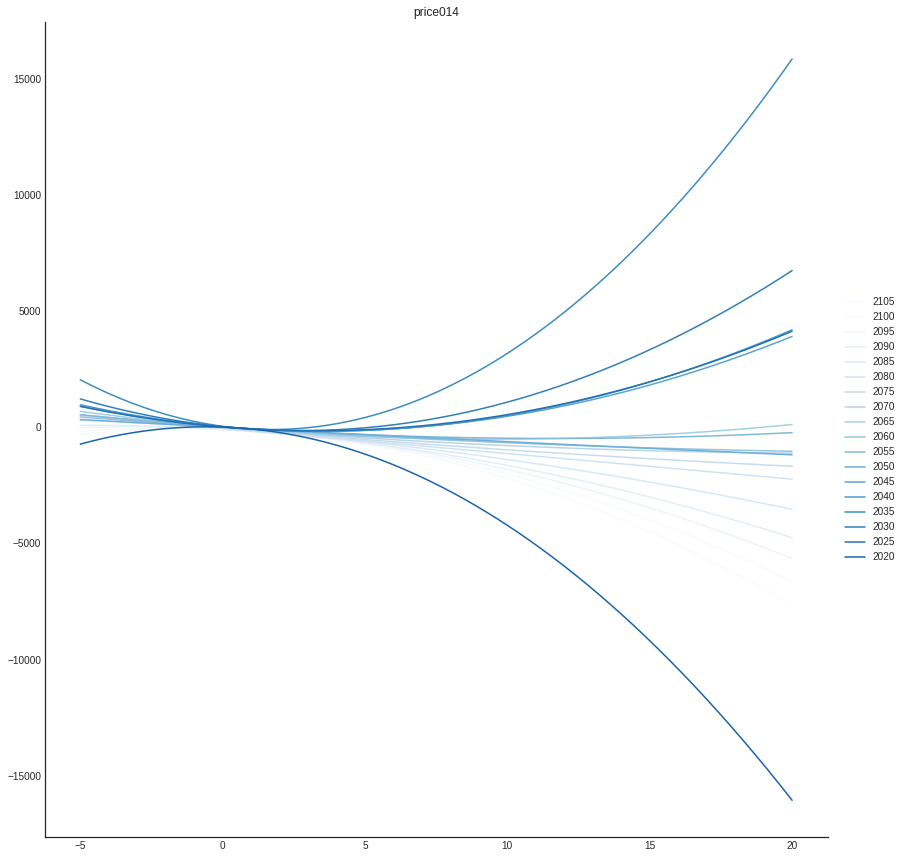

In [38]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = 1
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(["price014"]):

        lines = []
        for y in reversed(coeffs_all_years.year.values[:86:5]):

            lines.append(
                axes[0,0].plot(
                    temps.values,
                    spaghetti.sel(year=y).values,
                    color=matplotlib.cm.Blues_r((y-2000.0)/(2100-2000)),
                    label=int(y)))

        axes[0,0].set_facecolor('white')
        axes[0,0].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    plt.savefig('{}/figures/damage_function_plots/mean.pdf'.format(root))

    

/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


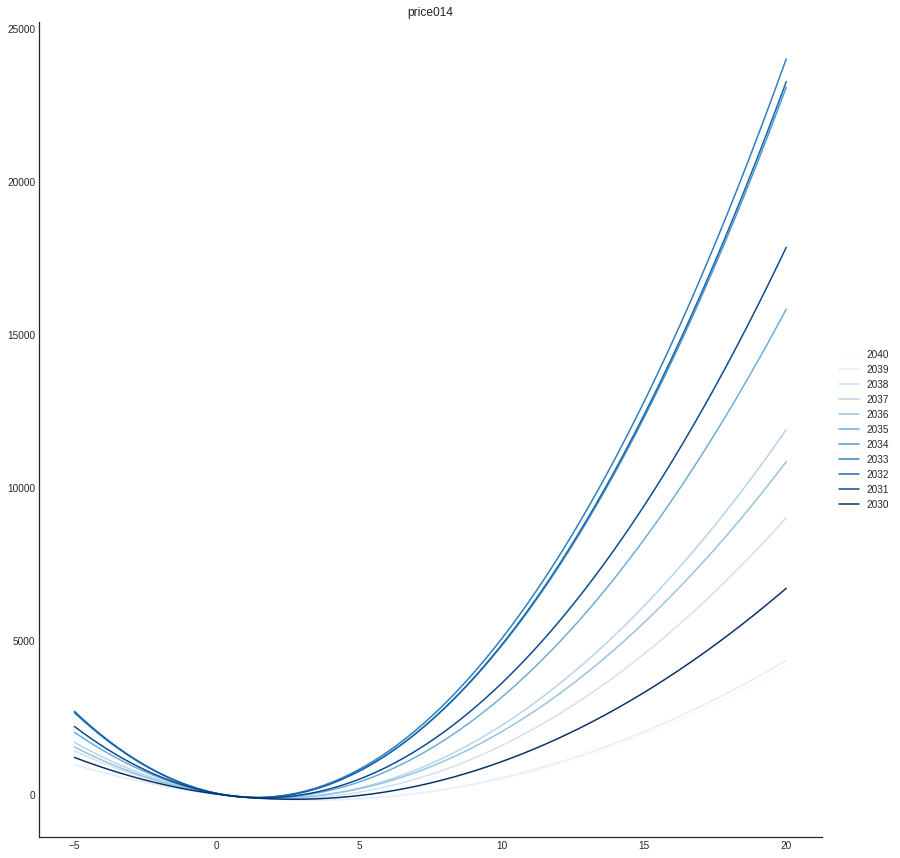

In [39]:
# plot for 2030 - 2040 only
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = 1
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(["price014"]):

        lines = []
        for y in reversed(coeffs_all_years.year.values[10:21:1]):

            lines.append(
                axes[0,0].plot(
                    temps.values,
                    spaghetti.sel(year=y).values,
                    color=matplotlib.cm.Blues_r((y-2030.0)/(2040-2030)),
                    label=int(y)))

        axes[0,0].set_facecolor('white')
        axes[0,0].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::1],
        labels=list(reversed(coeffs_all_years.year.values[10:21]))[::1],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    plt.savefig('{}/figures/damage_function_plots/mean_2030-2040.pdf'.format(root))

    

In [40]:
coeffs_all_years.year.values[10:21:1]

array([2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040])

In [41]:
# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
stem = "df_qreg_output_SSP3"
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})


/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/sit

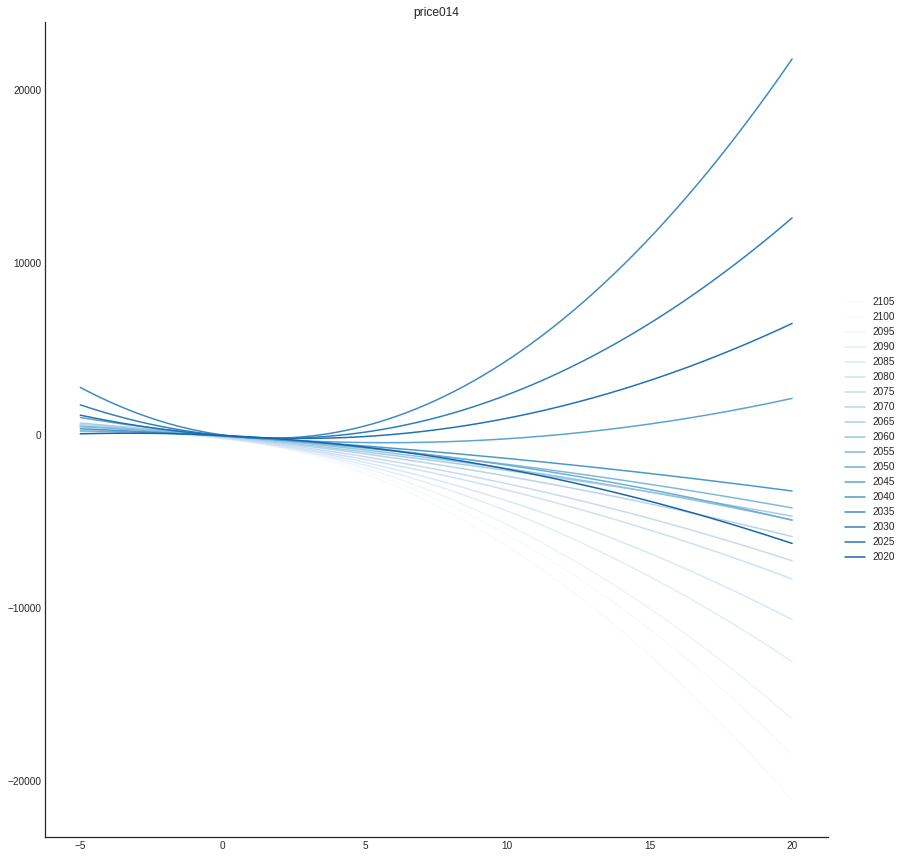

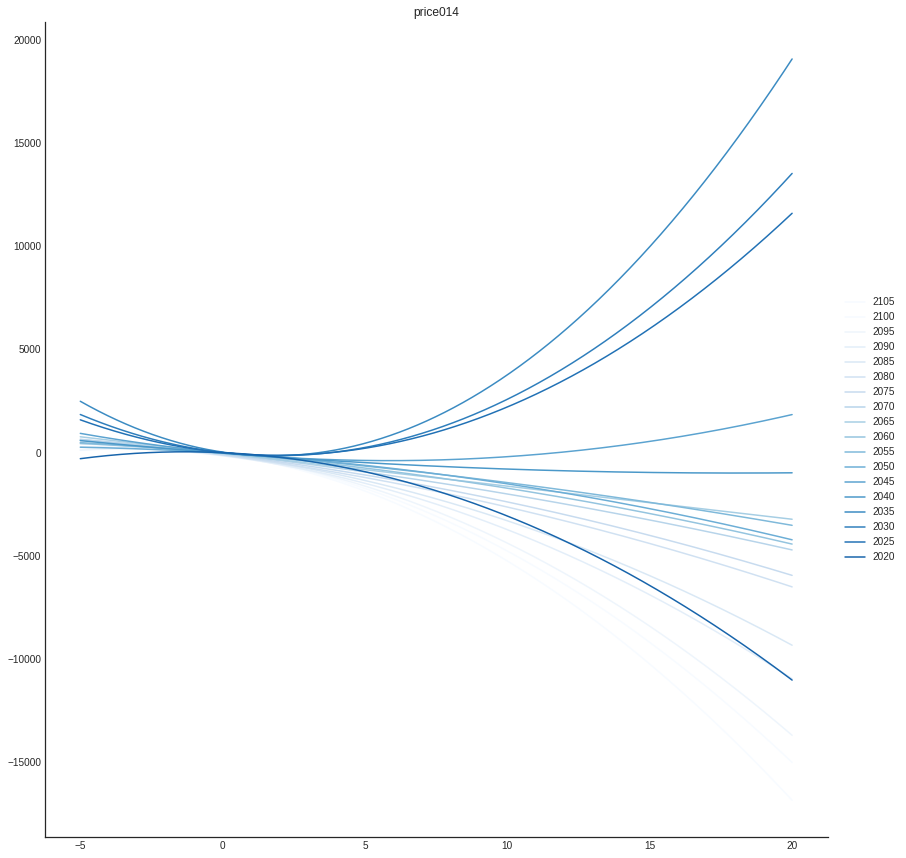

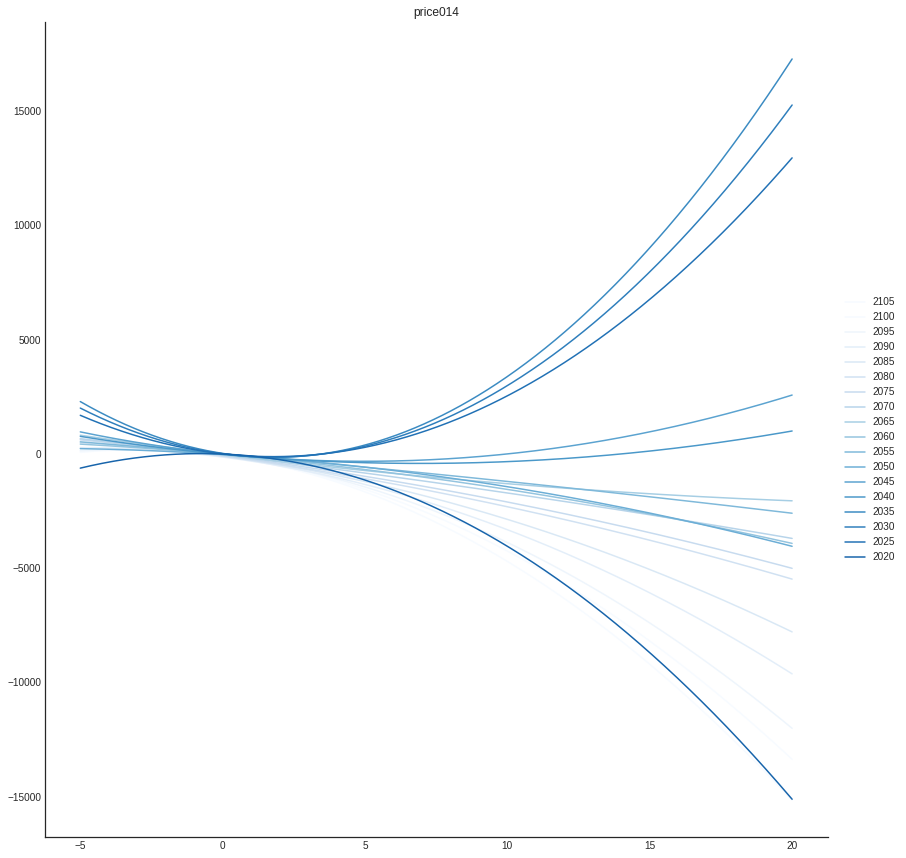

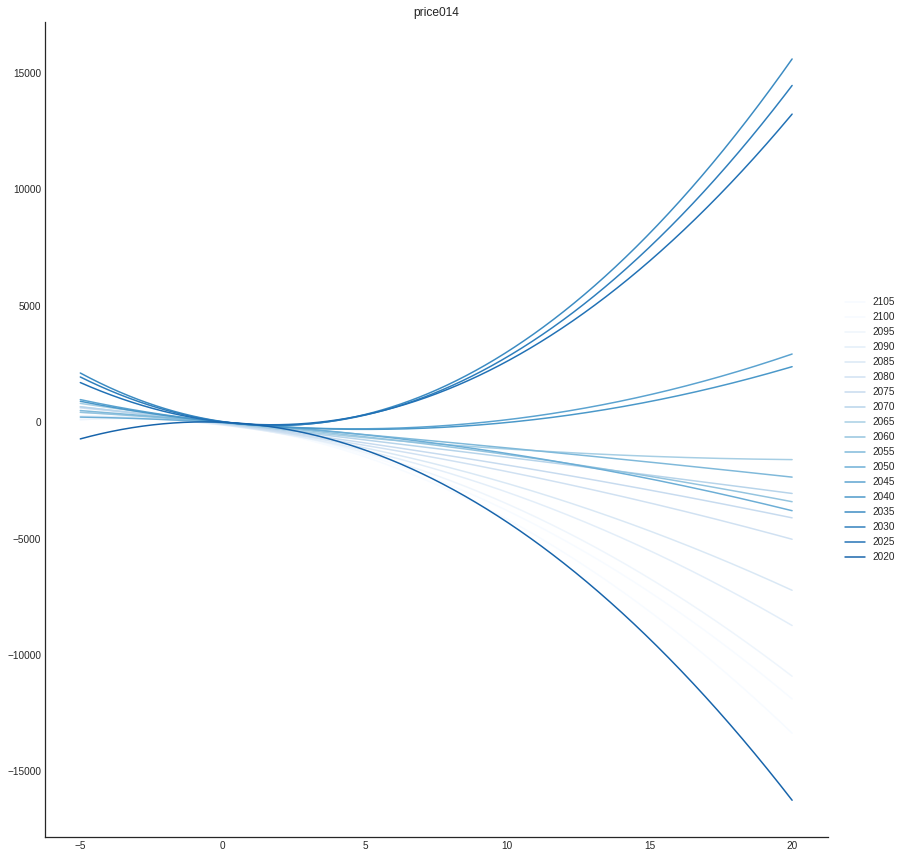

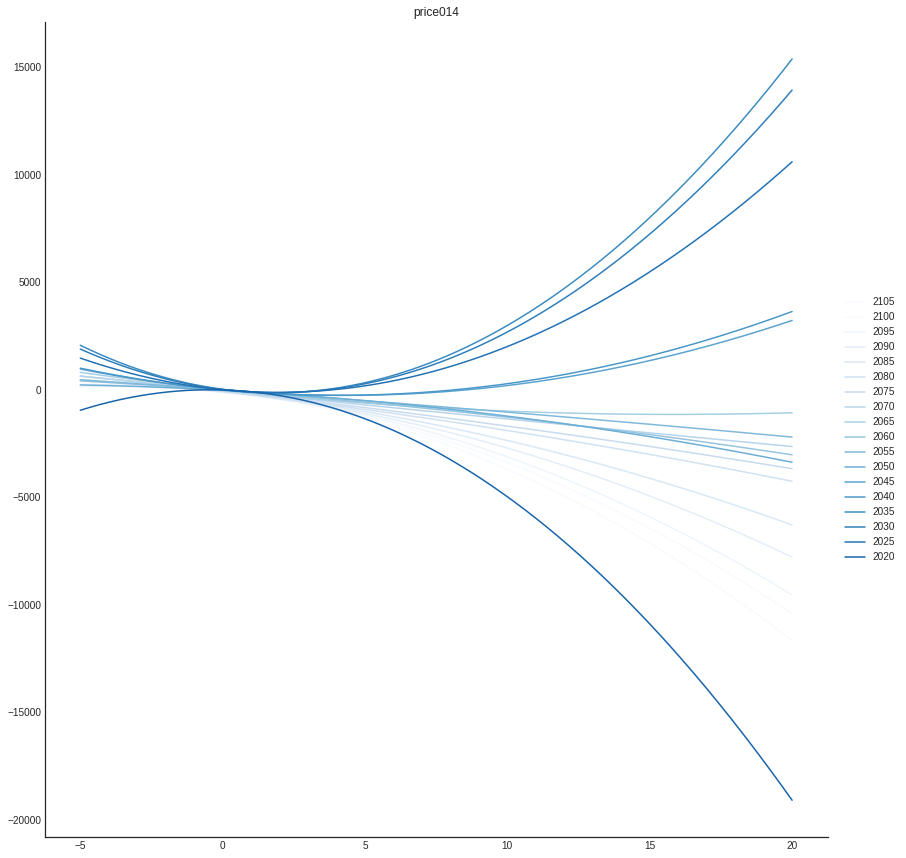

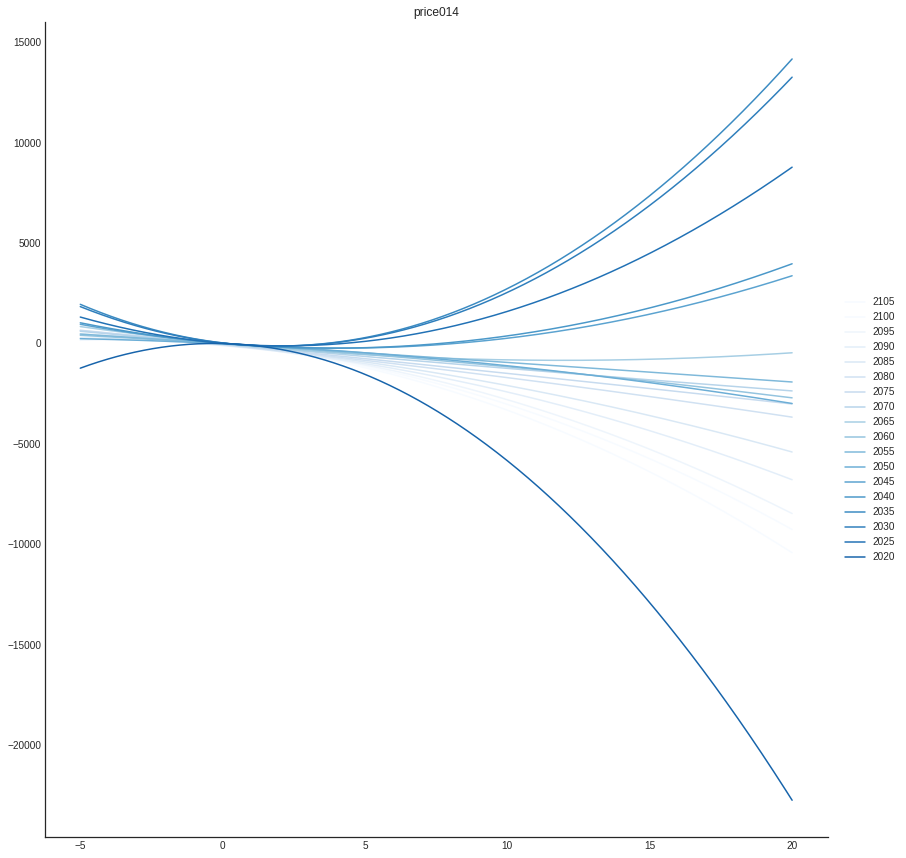

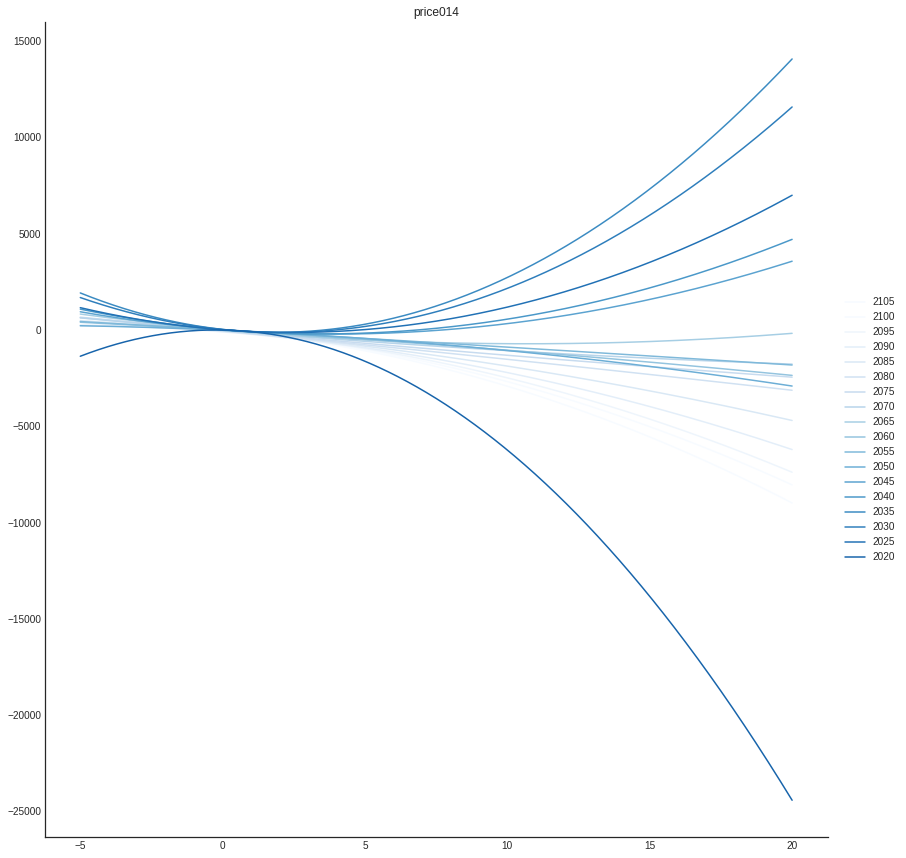

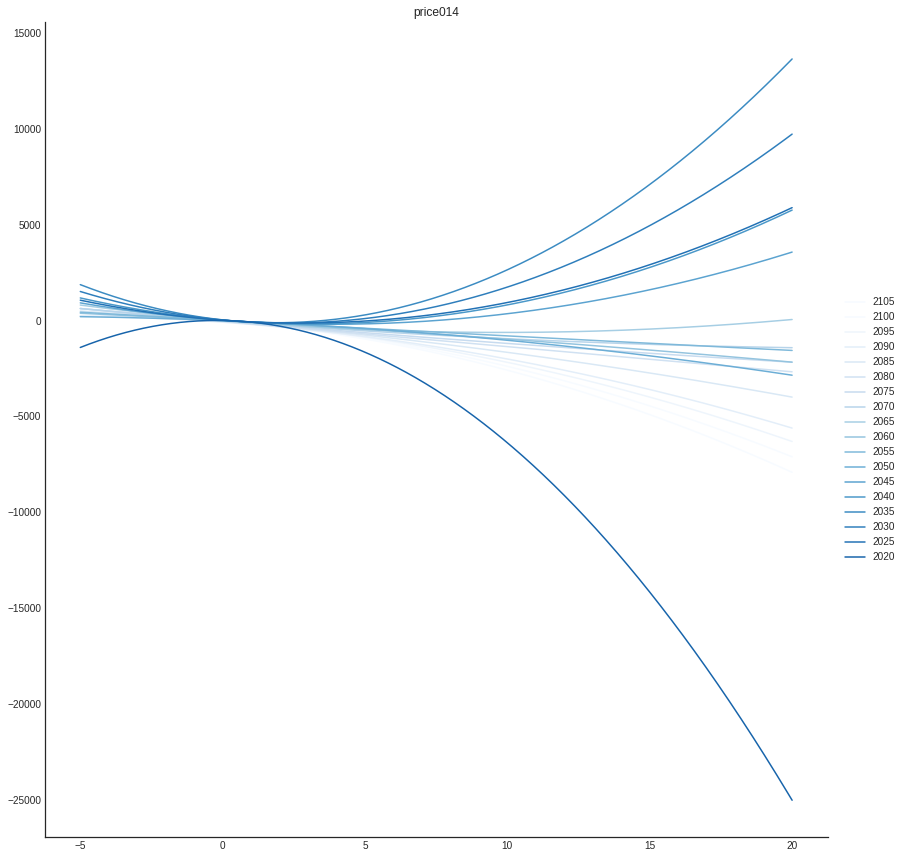

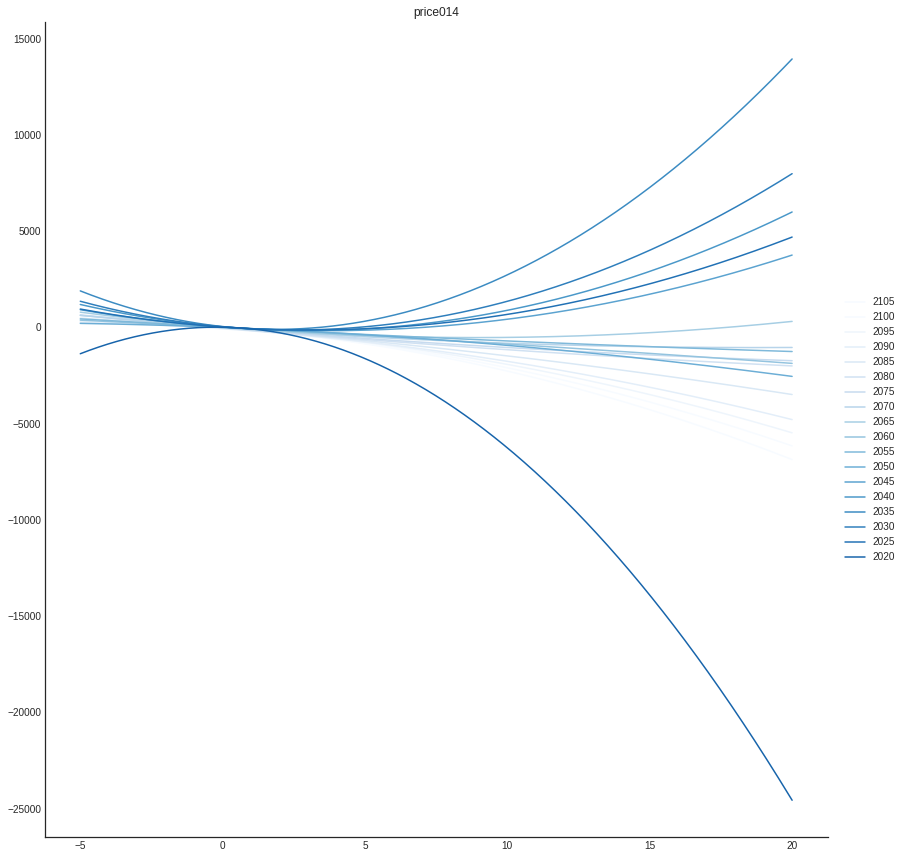

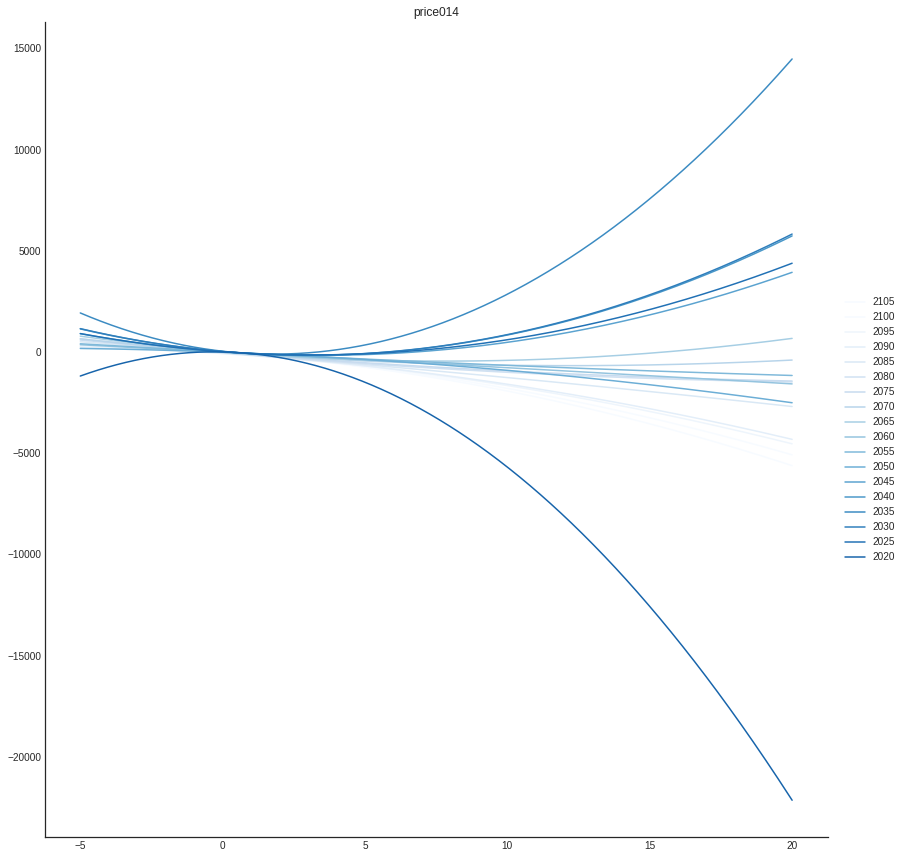

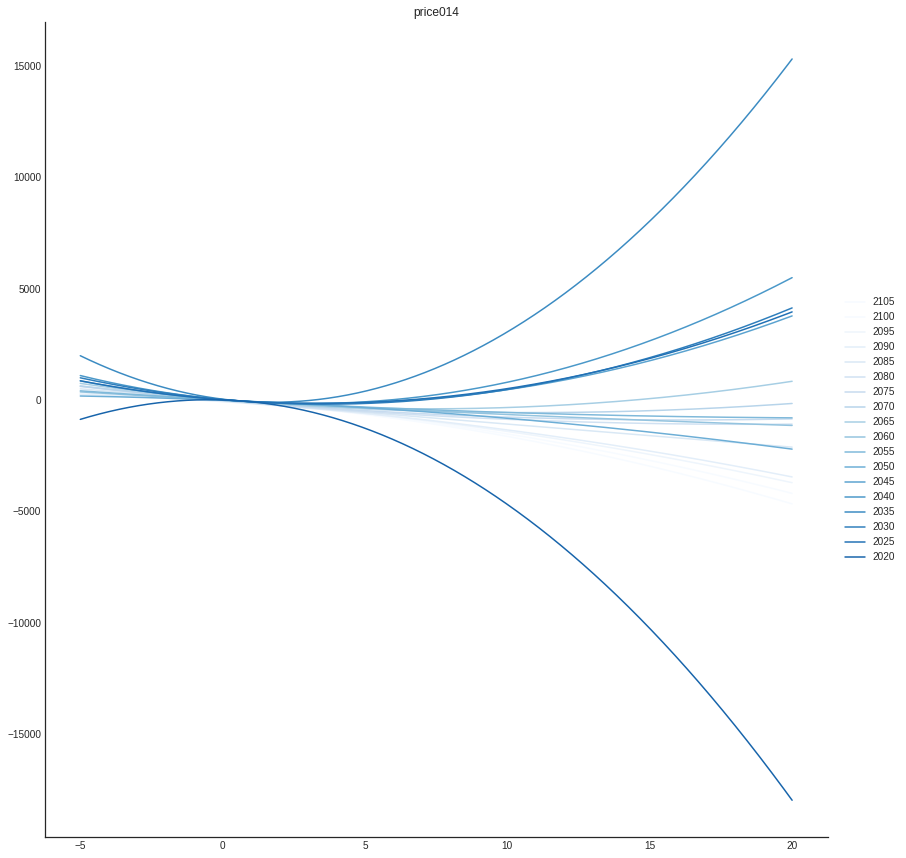

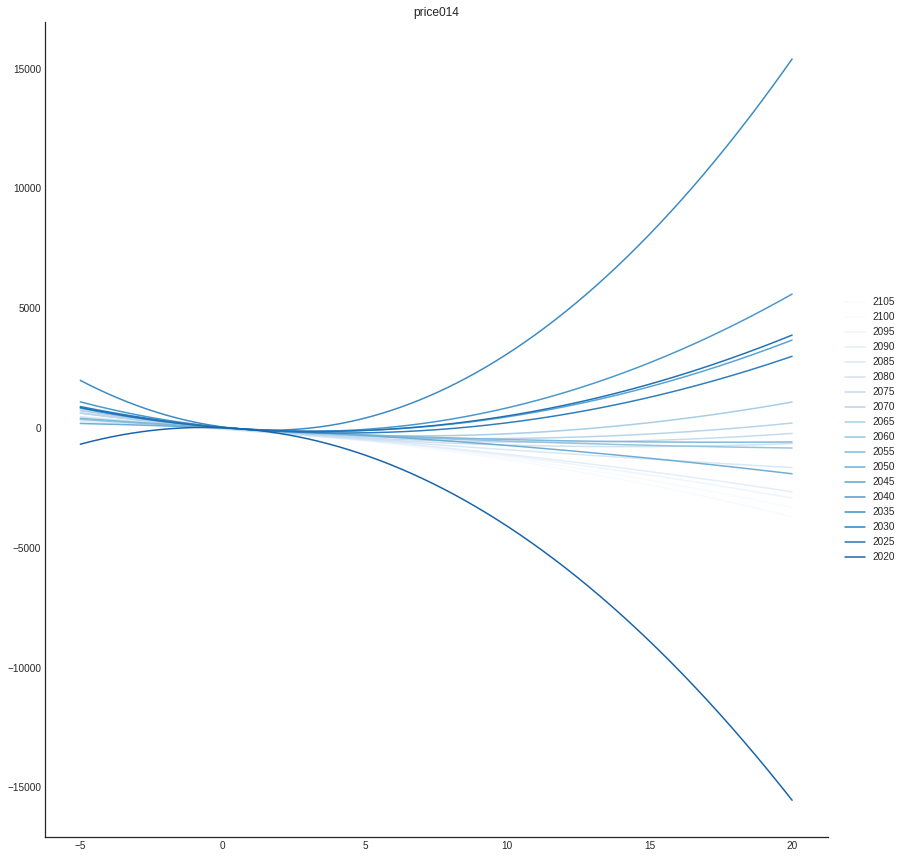

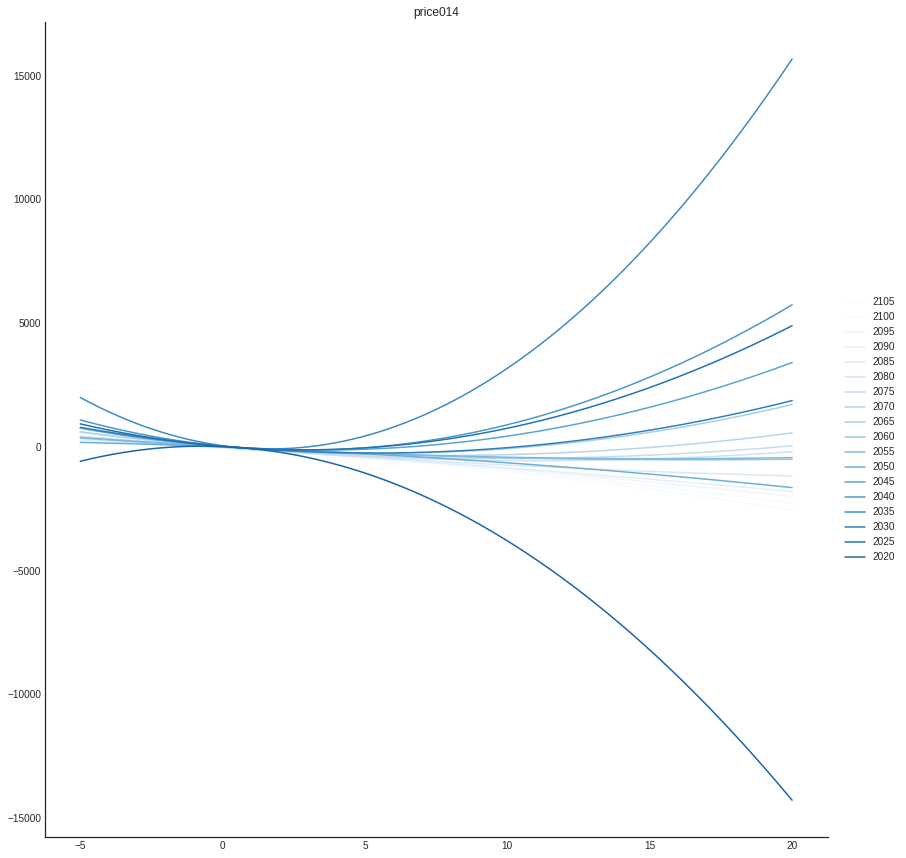

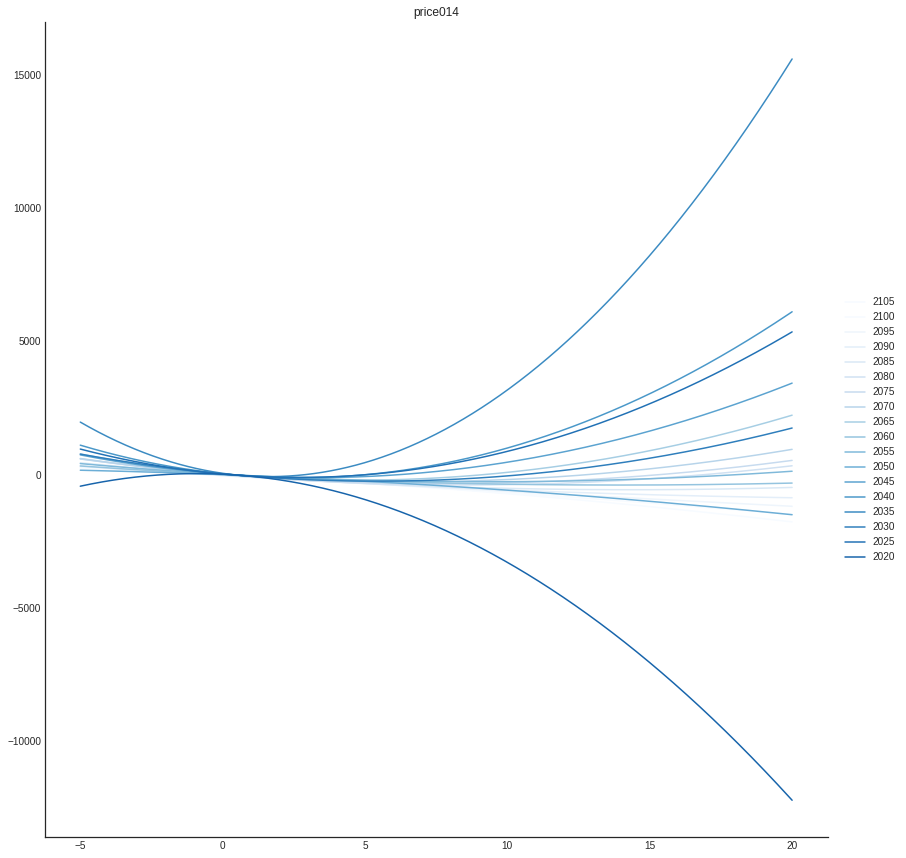

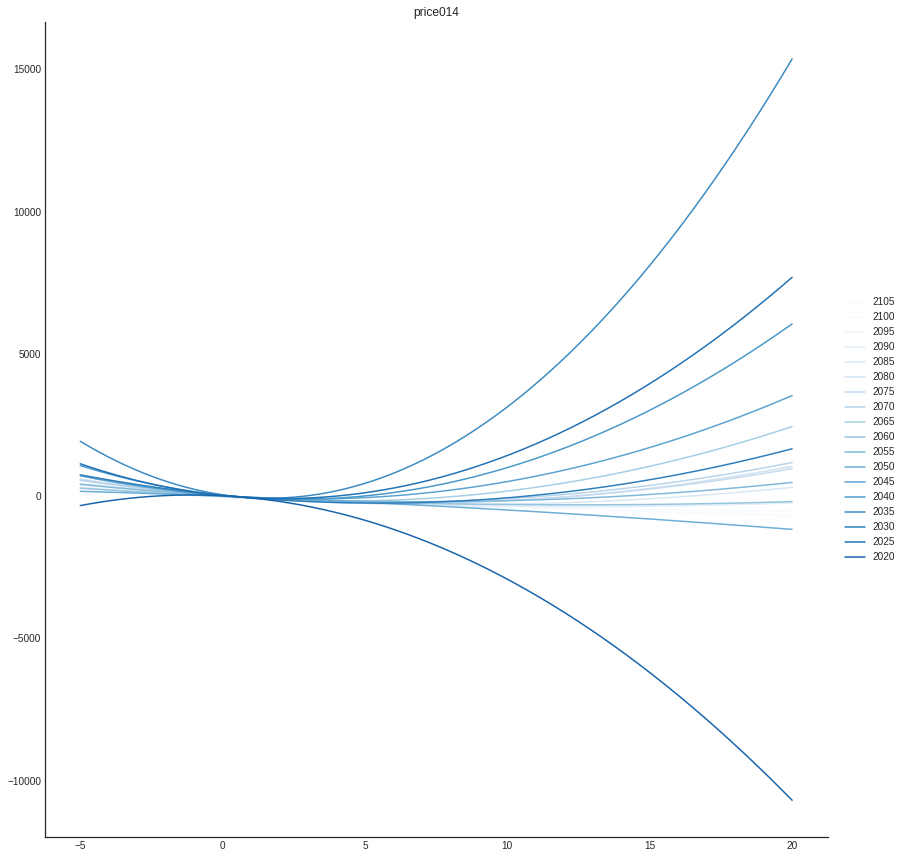

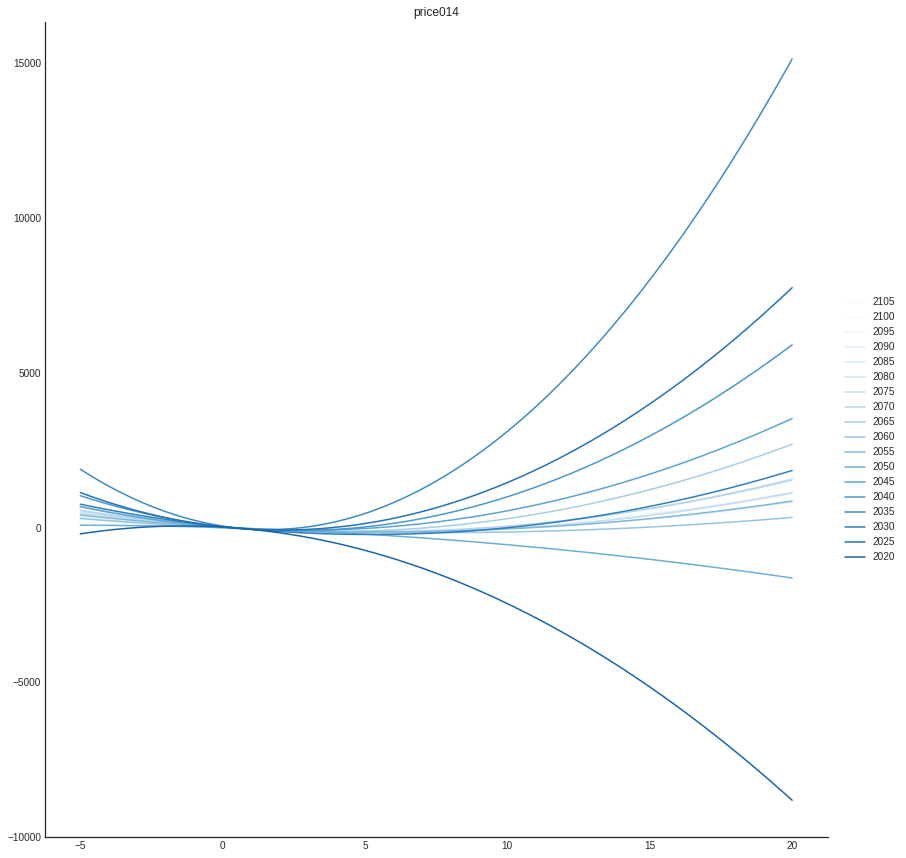

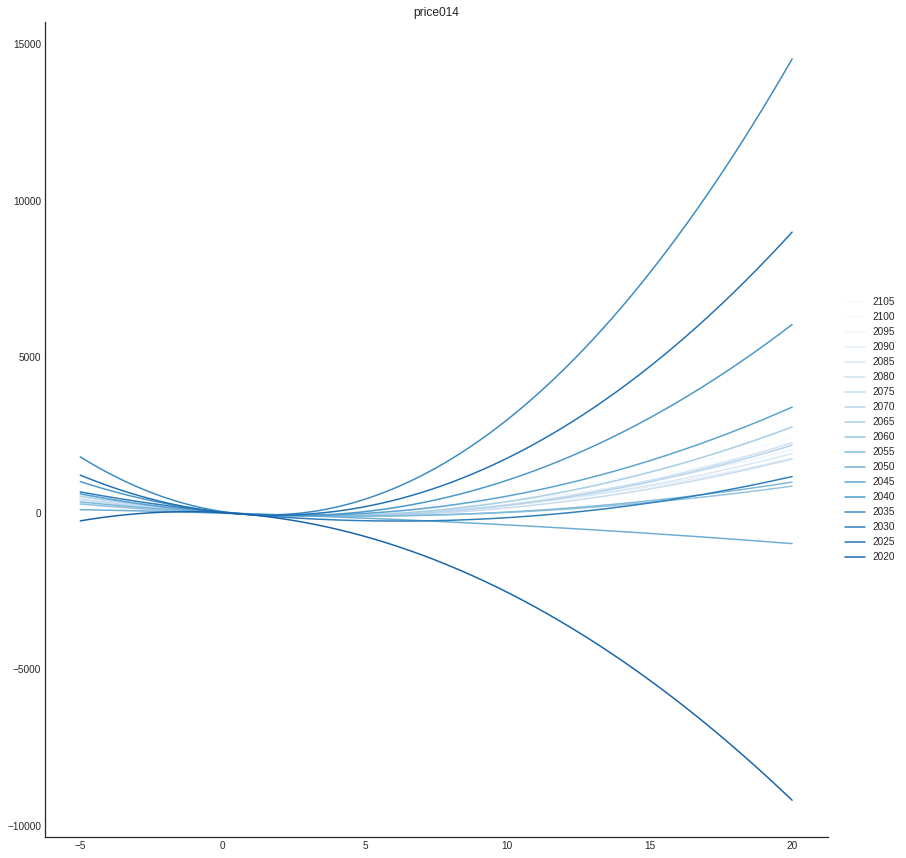

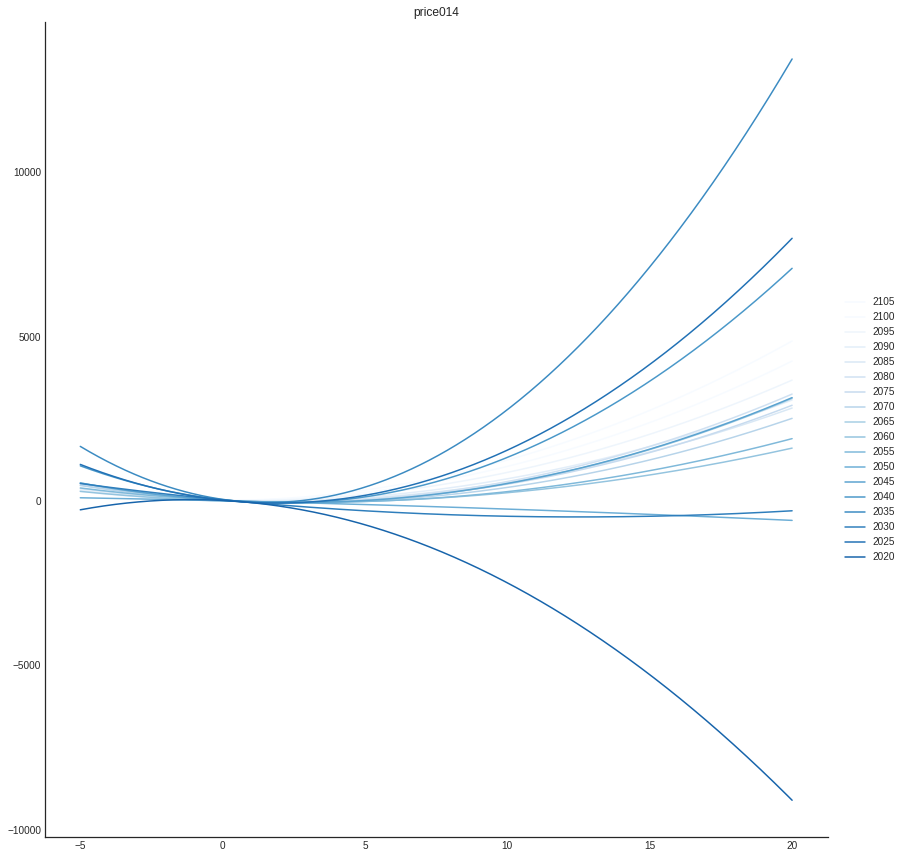

In [42]:
for quantile in range(5, 95, 5):
    # The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
    coeffs_all_years = (
        ds
        .to_array(dim='variable').to_series().unstack('year')
        .reindex(list(range(2020, 2301)), axis=1)
        .stack('year')
        .unstack('coeff')
        .to_xarray().sel(var_type = "price014").sel(pctile = (quantile / 100))
    )




    # The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
    # I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
    if hold_2100_damages_fixed:
        mask = coeffs_all_years['year'] > 2100
        coeffs_2100 = coeffs_all_years.sel(year=2100)
        coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)

    coeffs_all_years = coeffs_all_years.sel(variable=stem)
    coeffs_all_years


    powers = xr.DataArray(
            np.arange(0, 11),
            dims=['coeff'],
            coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

    if generate_plots:
        temps = np.linspace(-5, 20, 1101)
        temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

        numvars = 1
        fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

        if numvars == 1:
            axes = np.array([[axes]])

        # dot product of coeffs and powers of temp
        spaghetti = (
            (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

        for vi, v in enumerate(["price014"]):

            lines = []
            for y in reversed(coeffs_all_years.year.values[:86:5]):

                lines.append(
                    axes[0,0].plot(
                        temps.values,
                        spaghetti.sel(year=y).values,
                        color=matplotlib.cm.Blues_r((y-2000.0)/(2100-2000)),
                        label=int(y)))

            axes[0,0].set_facecolor('white')
            axes[0,0].set_title(v)

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()
        plt.savefig('{}/figures/damage_function_plots/quantiles_{}.pdf'.format(root,quantile))



/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


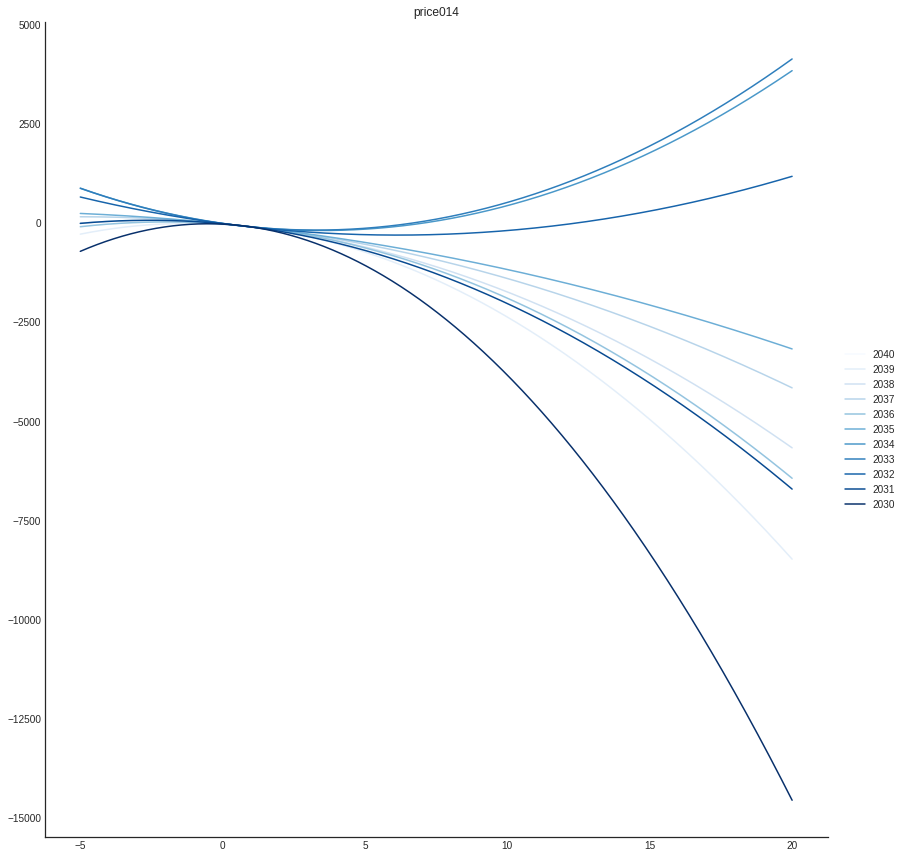

In [43]:
# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
INPUT_path = '{}/projection_system_outputs/damage_function_estimation/coefficients/'.format('/mnt/CIL_energy/code_release_data')
stem = "df_mean_output_SSP3"
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})



# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
coeffs_all_years = (
    ds.sel(placeholder='ss')
    .to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray().sel(growth_rate = "price014")
)


# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)


coeffs_all_years = coeffs_all_years.sel(variable=stem)


powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = 1
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(["price014"]):

        lines = []
        for y in reversed(coeffs_all_years.year.values[10:21:1]):

            lines.append(
                axes[0,0].plot(
                    temps.values,
                    spaghetti.sel(year=y).values,
                    color=matplotlib.cm.Blues_r((y-2030.0)/(2040-2030)),
                    label=int(y)))

        axes[0,0].set_facecolor('white')
        axes[0,0].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::1],
        labels=list(reversed(coeffs_all_years.year.values[10:21]))[::1],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    plt.savefig('{}/figures/damage_function_plots/mean_2030-2040_pre-country-income.pdf'.format(root))

    